# Randomization

*Elements of Data Science*

Copyright 2021 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ElementsOfDataScience/blob/master/11_inference.ipynb) or
[click here to download it](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/11_inference.ipynb).

Intro



## Vaccine Testing

Suppose you read a report about a new vaccine and the manufacturer says it is 67% effective at preventing disease.
You might wonder where that number comes from, what it means, and how confident we should be that it is correct.

Results like this often come from a [randomized controlled trial](https://en.wikipedia.org/wiki/Randomized_controlled_trial) (RCT), which works like this:

* You recruit a large group of volunteers and divide them into two groups at random: the "treatment group" receives the vaccine; the "control group" does not.

* Then you follow both groups for a period of time and record the number of people in each group who are diagnosed with the disease.

As an example, suppose you recruit 43,783 participants and they are assigned to groups with approximately the same size.

In [1]:
n_control = 21885
n_treatment = 21911

During the observation period, 468 people are diagnosed with the disease: 352 in the control group and 116 in the treatment group.

In [2]:
k_control = 352
k_treatment = 116

We can use these results to compute the risk of getting the disease for each group, in cases per 1000 people

In [3]:
risk_control = k_control / n_control * 1000
risk_control

16.084075851039522

In [4]:
risk_treatment = k_treatment / n_treatment * 1000
risk_treatment

5.294144493633334

The risk is substantially lower in the treatment group -- about 5.2 per 1000, compared to 16 -- which suggests that the vaccine is effective.
We can summarize these results by computing [relative risk](https://en.wikipedia.org/wiki/Relative_risk), which is the ratio of the two risks:

In [5]:
relative_risk = risk_treatment / risk_control
relative_risk

0.3291544097817203

The relative risk in this example is about 0.33, which means that the risk of disease in the treatment group is 33% of the risk in the control group.
Equivalently, we could report the complement of relative risk, which is **efficacy**:

In [6]:
efficacy = 1 - relative_risk
efficacy

0.6708455902182797

In this example the efficacy is `0.67`, which means that the vaccine reduces the risk of disease by 67%.

That's good news, but as skeptical data scientists, we should not assume that it is perfectly accurate.
There are any number of things that might have gone wrong.

For example, if people in the treatment group know they have been vaccinated, they might take fewer precautions to prevent disease, and people in the control group might be more careful.
That would affect the estimated efficacy, which is why a lot of trials are "blinded", meaning that the subjects don't know which group they are in.

The estimate would also be less accurate if people in either group don't follow the protocol.
For example, someone in the treatment group might not complete treatment, or someone in the control group might receive treatment from another source.

And there are many other possible sources of error, including honest mistakes and deliberate fraud.

In general it is hard to know whether estimates like this are accurate; nevertheless, there are things we can do to assess their quality.

When estimates are reported in scientific journals, they almost always include one of two measurements of uncertainty: a standard error or a confidence interval.
In the next section, I'll explain what they mean and show how to compute them.

## Simulating One Group

In our hypothetical example, there are 21 911 people in the treatment group and 116 of them got the disease, so the estimated risk is small.

In [7]:
n_treatment, k_treatment, risk_treatment

(21911, 116, 5.294144493633334)

But it's easy to imagine that there might have been a few more cases, or fewer, just by chance.
For example, if there had been 10 more cases, the estimated risk would be 5.8 per 1000, and if there had been 10 fewer, it would be 4.8.

In [8]:
126 / n_treatment * 1000, 106 / n_treatment * 1000

(5.750536260325863, 4.837752726940806)

That's a big enough difference that we should wonder how much variability there is in the estimate due to random variation.
We'll answer that question in three steps:

* We'll write a function that uses a random number generator to simulate the trial, then

* We'll run the function 1000 times to see how much the estimate varies.

* And we'll summarize the results.

The following function takes two parameters: `n` is the number of people in the group (treatment or control) and `p` is the probability that any of them gets the disease.

In [9]:
import numpy as np

def simulate_group(n, p):
    xs = np.random.random(size=n)
    k = np.sum(xs < p)
    return k / n * 1000

The first line generates an array of `n` random values between 0 and 1.
The values are distributed uniformly in this range, so the probability that each one is less than `p` is... `p`.

The second line counts how many of the values are less than `p`, that is, how many people in the simulated group get the disease.
Then the function returns the estimated risk.

Here's how we call this function, passing as arguments the size of the treatment group and the estimated risk:

In [10]:
p = k_treatment / n_treatment
simulate_group(n_treatment, p)

4.381360960248277

The result is the estimated risk from a simulated trial.
If we run this function 1000 times, it's like running the trial over and over.

In [11]:
np.random.seed(17)

In [12]:
t = [simulate_group(n_treatment, p)
     for i in range(1000)]

The result is a list of estimated risks that shows how much we expect the results of the trial to vary due to randomness.
We can use a KDE plot to visualize the distribution of these estimates

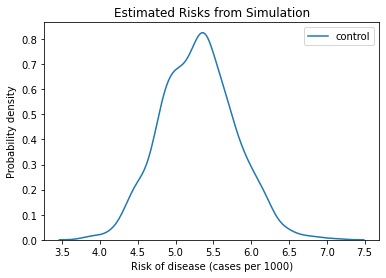

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(t, label='control')

plt.xlabel('Risk of disease (cases per 1000)')
plt.ylabel('Probability density')
plt.title('Estimated Risks from Simulation')
plt.legend();

The mean of this distribution is about 5.3, which is close to the observed risk, as we should expect.

In [14]:
np.mean(t), risk_treatment

(5.299210442243623, 5.294144493633334)

The width of this distribution indicates how much variation there is in the estimate due to randomness.
One way to quantify the width of the distribution is the standard deviation.

In [15]:
standard_error = np.std(t)
standard_error

0.48944411243624414

This result is called the [**standard error**](https://en.wikipedia.org/wiki/Standard_error).

Another way to quantify the width of the distribution is an interval between two percentiles.
For example, if we compute the 5th and 95th percentiles, the interval we get contains 90% of the simulated estimates.

In [16]:
confidence_interval = np.percentile(t, [5, 95])
confidence_interval

array([4.47263931, 6.11793163])

This result is called a [**confidence interval**](https://en.wikipedia.org/wiki/Confidence_interval); specifically, this one is a "90% confidence interval", or 90% CI.
If we assume that the observed risk is correct, and we run the same trial many times, we expect 90% of the estimates to fall in this interval.

Standard errors and confidence intervals quantify our uncertainty about the estimate due to random variation from one trial to another.

## Simulating the Trial

If that's not making sense yet, let's try another example.  In the previous section we simulated one group and estimated their risk.
Now we'll simulate both groups and estimate the efficacy of the vaccine.

The following function takes as parameters the size of the two groups and their actual risks.

In [17]:
def simulate_trial(n1, p1, n2, p2):
    risk1 = simulate_group(n1, p1)
    risk2 = simulate_group(n2, p2)
    efficacy = 1 - risk2 / risk1
    return efficacy

If we call this function once, it simulates both groups, computes their risks in each group, and uses the results to estimate the efficacy of the treatment (assuming that the first group is the control).

In [18]:
p1 = k_control / n_control
p2 = k_treatment / n_treatment
simulate_trial(n_control, p1, n_treatment, p2)

0.6891301291299345

If we call it 1000 times, the result is estimated efficacy from 1000 simulated trials.

In [19]:
t2 = [simulate_trial(n_control, p1, n_treatment, p2)
      for i in range(1000)]

Again, we can use a KDE plot to visualize the distribution of these estimates.

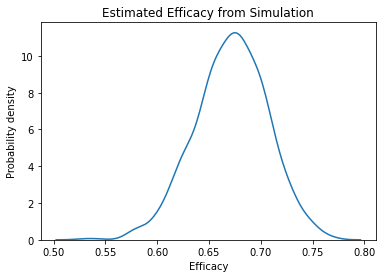

In [20]:
sns.kdeplot(t2)

plt.xlabel('Efficacy')
plt.ylabel('Probability density')
plt.title('Estimated Efficacy from Simulation');

Again, the mean of this distribution is close to the efficacy we computed with the results of the actual trial.

In [21]:
np.mean(t2), efficacy

(0.6713727268668117, 0.6708455902182797)

The standard deviation of this distribution is the standard error of the estimate.

In [22]:
np.std(t2)

0.035068503707114076

In a scientific paper, we could report the estimated efficacy and standard error as 0.67 (SE 0.035).
As an alternative, we can use percentiles to compute a 90% confidence interval.

In [23]:
np.percentile(t2, [5, 95])

array([0.61344412, 0.72785182])

In a scientific paper, we could report these results as 0.67, 90% CI [0.61, 0.72]".

The standard error and confidence interval represent nearly the same information.
In general, I prefer to report a confidence interval because it is easier to interpret.

Formally, it means that if we run the same experiment again, we expect 90% of the results to fall between 61% and 72% (assuming that the estimated risks are correct).

More casually, it means that it is plausible that the actually efficacy is as low as 61%, or as high as 72% (assuming there are no sources of error other than random variation).

## Estimating Means

In the previous examples, we've estimated risk, which is a proportion, and efficacy, which is a ratio of two proportions.
As a third example, let's estimate a mean.

Suppose we want to estimate the average height of men in the United States.
It would be impractical to measure everyone in the country, but if we choose a random sample of the population and measure the people in the sample, we can use the mean of the measurements to estimate the mean of the population.

Ideally, the sample should be **representative**, which means that everyone in the population has an equal chance of appearing in the sample.
In general, that's not easy to do.
Depending on how you recruit people, your sample might have too many tall people or too many short people.

But let's suppose we have a representative sample of 103 adult males in the United States, the average height in the sample is 177 cm and the standard deviation is 8.4 cm.

If someone asks for your best guess about the height of mean in the U.S., you would report 177 cm.
But how accurate do you think this estimate is?
If you only measure 100 people from a population of about 100 million adult males, it seems like the average in the population might be substantially higher or lower.

Again, we can use random simulation to quantify the uncertainty of this estimate.
As we did in the previous examples, we will assume for purposes of simulation that the estimates are correct, and simulate the sampling process 1000 times.

The following function takes as parameters the size of the sample, `n`, the presumed average height in the population, `mu`, and the presumed standard deviation, `std`. 

In [24]:
def simulate_sample_mean(n, mu, sigma):
    sample = np.random.normal(mu, sigma, size=n)
    return sample.mean()

This function generates `n` random values from a normal distribution with the given mean and standard deviation, and returns their mean.

We can run it like this, using the observed mean and standard deviation from the sample as the presumed mean and standard deviation of the population.

In [25]:
n_height = 103
mean_height = 177
std_height = 8.4

simulate_sample_mean(n_height, mean_height, std_height)

177.68434963290943

If we run it 1000 times, it simulates the sampling and measurement process and returns a list of results from 1000 simulated experiments.

In [26]:
t3 = [simulate_sample_mean(n_height, mean_height, std_height)
      for i in range(1000)]

Again, we can use a KDE plot to visualize the distribution of these values.

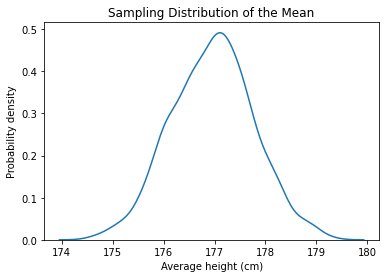

In [27]:
sns.kdeplot(t3)

plt.xlabel('Average height (cm)')
plt.ylabel('Probability density')
plt.title('Sampling Distribution of the Mean');

This distribution is called a [**sampling distribution**]() because it represents the variation in the results due to the random sampling process.
If we recruit 100 people and compute the mean of their heights, the result might be as low as 175 cm, or as high as 179 cm, due to chance.

The average of the sampling distribution is close to the presumed mean of the population.

In [28]:
np.mean(t3), mean_height

(176.9607008614284, 177)

The standard deviation of the sampling distribution is the standard error of the estimate.

In [29]:
np.std(t3)

0.8058714867150188

And we can use `percentile` to compute a 90% confidence interval.

In [30]:
np.percentile(t3, [5, 95])

array([175.63978221, 178.29356294])

If I reported this result in a paper, I would say that the estimated height of adult male residents of the U.S. is 177 cm, 90% CI [176, 178] cm.

Informally, that means that the estimate could plausibly be off by about a centimeter either way, just due to random sampling.
But we should remember that there are other possible sources of error, so we might be off by more than that.

The confidence interval puts an upper bound on the precision of the estimate; in this example, the precision of the estimate is 1 cm at best, and might worse.

## The Randomization Framework

The examples we've done so far fit into the framework in this diagram:

![](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/figs/resampling.png)

Using data from an experiment, we compute a sample statistic.  In the vaccine example, we computed risks for each group and efficacy.  In the height example, we computed the average height in the sample.

Then we build a model of the sampling process.
In the vaccine example, the model assumes that everyone in each group has the same probability of getting sick, and we use the data to choose the probability.
In the height example, the model assumes that heights are drawn from a normal distribution, and we use the data to choose the parameters `mu` and `sigma`.

We use the model to simulate the experiment many times.  Each simulation generates a dataset that's similar to the original, which we use to compute the sample statistic.

Finally, we collect the sample statistics from the simulations and use them to plot the sampling distribution and compute standard errors and confidence intervals.

I emphasize the role of the model in this framework because for a given experiment there might be several possible models, each including some elements of the real world and ignoring others.

For example, our model of the vaccine experiment assumes that everyone in each group has the same risk, but that's probably not true.
Here's another version of `simulate_group` that includes variation in risk within each group.

In [31]:
def simulate_variable_group(n, p):
    ps = np.random.uniform(0, 2*p, size=n)
    xs = np.random.random(size=n)
    k = np.sum(xs < ps)
    return k / n * 1000

This version of the function generates `ps`, which is an array of probabilities uniformly distributed between `0` and `2*n`.
Of course, that's just a guess about how the probabilities might be distributed in the group, but we can use it to get a sense of what effect this distribution has on the results.

The rest of the function is the same a the previous version: it generates `xs`, which is an array of random values between `0` and `1`.
Then it compares `xs` and `ps`, counting the number of times `p` exceeds `x`.

Here's how we call this function, simulating the treatment group.

In [32]:
p = k_treatment / n_treatment
simulate_variable_group(n_treatment, p)

5.339783670302587

The return value is the number of cases per 1000.

**Exercise:** Using this function to run 1000 simulations of the treatment group.  Compute the mean of the results and confirm that it is close to the observed `risk_treatment`.  To quantify the spread of the sampling distribution, compute the standard error.  How does it compare to the standard error we computed with the original model, where everyone in the group has the same risk? 

In [33]:
# Solution

t4 = [simulate_variable_group(n_treatment, p)
     for i in range(1000)]

In [34]:
# Solution

np.mean(t4), risk_treatment

(5.2897174934964175, 5.294144493633334)

In [35]:
# Solution

# The standard error is a little smaller with the modified model

np.std(t4), np.std(t)

(0.48952264960348074, 0.48944411243624414)

**Exercise:** The following is a version of `simulate_trial` that uses `simulate_variable_group`, from the previous exercise, to simulate the vaccine trial using the modified model, with variation in risk within the groups.

Use this function to simulate 1000 trials.  Compute the mean of the sampling distribution and confirm that it is close to the observed `efficacy`.  Compute the standard error and compare it to the standard error we computed for the original model

In [36]:
def simulate_variable_trial(n1, p1, n2, p2):
    risk1 = simulate_variable_group(n1, p1)
    risk2 = simulate_variable_group(n2, p2)
    efficacy = 1 - risk2 / risk1
    return efficacy

In [37]:
# Solution

p1 = k_control / n_control
p2 = k_treatment / n_treatment
simulate_variable_trial(n_control, p1, n_treatment, p2)

0.7060783539089954

In [38]:
# Solution

t5 = [simulate_variable_trial(n_control, p1, n_treatment, p2)
      for i in range(1000)]

In [39]:
# Solution

np.mean(t5), efficacy

(0.6718099644090157, 0.6708455902182797)

In [40]:
# Solution

# The standard error is a little smaller with the modified model

np.std(t5), np.std(t2)

(0.035858846807684176, 0.035068503707114076)

**Exercise:** One nice thing about the randomization framework is that it is easy to compute the sampling distribution for other statistics.

For example, suppose we want to estimate the coefficient of variation (standard deviation as a fraction of the mean) for adult male height.  Here's how we can compute it.

In [41]:
cv = std_height / mean_height
cv

0.04745762711864407

In this example, the standard deviation is about 5% of the mean. 
The following is a version of `simulate_sample` that generates a random sample of heights and returns the coefficient of variation, rather than the mean. 

In [42]:
def simulate_sample_cv(n, mu, sigma):
    sample = np.random.normal(mu, sigma, size=n)
    return sample.std() / sample.mean()

Use this function to simulate 1000 samples with size `n=103`, using `mean_height` for `mu` and `std_height` for `sigma`.  Plot the sampling distribution of the coefficient of variation, and compute a 90% confidence interval.

In [43]:
# Solution

t6 = [simulate_sample_cv(n_height, mean_height, std_height)
      for i in range(1000)]

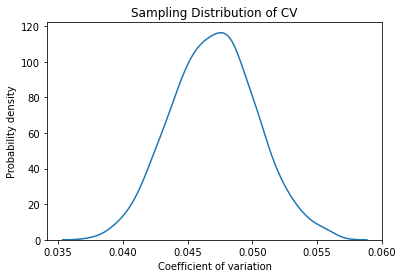

In [44]:
# Solution

sns.kdeplot(t6)

plt.xlabel('Coefficient of variation')
plt.ylabel('Probability density')
plt.title('Sampling Distribution of CV');

In [45]:
np.percentile(t6, [5, 95])

array([0.04174409, 0.05249667])

**Exercise:** In Chapter 10 we used data from the General Social Survey, specifically a variable called `GUNLAW`, to describe support for a gun control law as a function of age, sex, and years of education.
Now let's come back to that dataset and see how the responses have changed over time.

The following cell reloads the data.

In [46]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/' +
         'ElementsOfDataScience/raw/master/data/gss_eda.hdf')

In [47]:
import pandas as pd

gss = pd.read_hdf('gss_eda.hdf', 'gss')

The column named `GUNLAW` records responses to the question "Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?"

The response code `1` means yes; `2` means no.  It will be easier to work with this variable if we recode it so `0` means no.

In [48]:
gss['GUNLAW'].replace(2, 0, inplace=True)
gss['GUNLAW'].value_counts()

1.0    32038
0.0     9975
Name: GUNLAW, dtype: int64

For each year of the survey, I would like to compute the number of respondents and the number who said they favor this law.
I'll use `groupby` to group the respondents by year of interview and `agg` to compute two aggregation functions, `sum` and `count`.

In [49]:
grouped = gss.groupby('YEAR')['GUNLAW']
agg = grouped.agg(['sum', 'count'])
agg.head()

,sum,count
YEAR,,
1972,1131.0,1562
1973,1099.0,1470
1974,1112.0,1459
1975,1096.0,1450
1976,1068.0,1472


The result is a `DataFrame` with two columns: `sum` is the number of respondents who said "yes"; `count` is the number of respondents who were asked the question.

In some years the question was not asked, so I'll use `drop` to remove those rows.

In [50]:
zero = (agg['count'] == 0)
labels = agg.index[zero]
agg.drop(labels, inplace=True)

In [51]:
assert (gss['GUNLAW'].value_counts().sum()
        == agg['count'].sum())

Now we can plot the percentage of respondents who favor gun control (at least for this wording of the question) during each year.

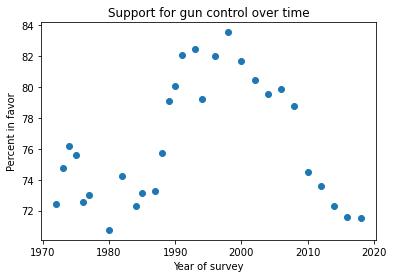

In [52]:
percent = agg['sum'] / agg['count'] * 100
percent.plot(style='o')

plt.xlabel('Year of survey')
plt.ylabel('Percent in favor')
plt.title('Support for gun control over time');

The results vary from year to year.  It is hard to tell how much of this variation is due to real changes in opinion, and how much is due to random sampling.
We can answer that question by computing confidence intervals for each of these data points.

Here is a version of `simulate_group` that returns results as a percentage, rather than per 1000.

In [53]:
def simulate_group_percent(n, p):
    xs = np.random.random(size=n)
    k = np.sum(xs < p)
    return k / n * 100

Write a loop that goes through the rows in `agg` and computes a confidence interval for each year.
You can use `itertuples` to iterate the rows, like this:

```
for year, k, n in agg.itertuples():
    print(year, k, n)
```

For each row, compute a 90% confidence interval and plot it as a vertical line.
Then plot the data points and label the axes.
The result should give you a sense of how much variation we expect to see from year to year due to random sampling.

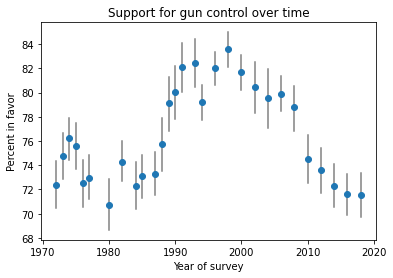

In [54]:
# Solution

for year, k, n in agg.itertuples():
    p = k / n
    t7 = [simulate_group_percent(n, p)
         for i in range(1000)]
    ci = np.percentile(t7, [5, 95])
    plt.plot([year, year], ci, 'gray')
    
percent.plot(style='o')

plt.xlabel('Year of survey')
plt.ylabel('Percent in favor')
plt.title('Support for gun control over time');